In [75]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [76]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training_Digital-Persona.csv')


In [77]:
test = pd.read_csv('/content/drive/MyDrive/CSV/TestingDigitalPersona.csv')

In [78]:
train.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,LCS,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2
0,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,1033.0,0.192565,0.965358,419,223,107.718476,1,0.106709,0.166449,...,0.805730,0.827971,0.487488,1.404403,0.071551,0.047816,0.088733,0.095556,0.143455,0.040381
1,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,864.5,0.184950,0.967039,302,144,113.864787,1,0.094668,0.202578,...,0.789452,0.696368,0.502754,1.522737,0.069966,0.054683,0.132886,0.092978,0.107935,0.040792
2,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,1488.0,0.187642,0.966452,458,228,105.423684,1,0.111087,0.058595,...,0.820833,0.684265,0.484818,1.583170,0.076095,0.035939,0.131698,0.120344,0.268805,0.044596
3,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,1287.0,0.177059,0.969040,396,197,122.923574,1,0.096435,0.129141,...,0.812243,0.491710,0.448238,1.387128,0.054967,0.037768,0.210576,0.156784,0.182722,0.043440
4,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,1241.5,0.185612,0.966522,372,249,85.873036,1,0.098914,0.124638,...,0.832742,0.536342,0.462497,1.747025,0.079089,0.046778,0.216615,0.112946,0.144860,0.046648


In [79]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = "train"    
train_indices = train[train.Set=="train"].index

In [81]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [82]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Filename 1906
Class 2
Set 1


In [83]:
train.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,953,1033.0,0.192565,0.965358,419,223,107.718476,1,0.106709,0.166449,...,0.827971,0.487488,1.404403,0.071551,0.047816,0.088733,0.095556,0.143455,0.040381,0
1,954,864.5,0.184950,0.967039,302,144,113.864787,1,0.094668,0.202578,...,0.696368,0.502754,1.522737,0.069966,0.054683,0.132886,0.092978,0.107935,0.040792,0
2,955,1488.0,0.187642,0.966452,458,228,105.423684,1,0.111087,0.058595,...,0.684265,0.484818,1.583170,0.076095,0.035939,0.131698,0.120344,0.268805,0.044596,0
3,956,1287.0,0.177059,0.969040,396,197,122.923574,1,0.096435,0.129141,...,0.491710,0.448238,1.387128,0.054967,0.037768,0.210576,0.156784,0.182722,0.043440,0
4,957,1241.5,0.185612,0.966522,372,249,85.873036,1,0.098914,0.124638,...,0.536342,0.462497,1.747025,0.079089,0.046778,0.216615,0.112946,0.144860,0.046648,0


In [84]:
nunique = test.nunique()
types = test.dtypes
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Filename 2391
Class 2
Set 1


In [85]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"
test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [89]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [90]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

Device used : cpu


In [91]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]


In [92]:
X_train[0]

array([9.53000000e+02, 1.03300000e+03, 1.92564745e-01, 9.65358153e-01,
       4.19000000e+02, 2.23000000e+02, 1.07718476e+02, 1.06709268e-01,
       1.66449291e-01, 2.36124351e-01, 3.84674254e+03, 1.76037291e-01,
       3.53598044e-01, 9.82517729e-01, 9.69387755e-01, 8.84407064e+01,
       1.77051122e+02, 7.10952231e-01, 8.05729733e-01, 8.27971101e-01,
       4.87488476e-01, 1.40440324e+00, 7.15508270e-02, 4.78157540e-02,
       8.87332410e-02, 9.55558720e-02, 1.43454731e-01, 4.03807280e-02])

In [93]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [94]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 1.31212 | train_auc: 0.5142  | valid_auc: 0.53915 |  0:00:00s
epoch 1  | loss: 0.84924 | train_auc: 0.47908 | valid_auc: 0.45503 |  0:00:00s
epoch 2  | loss: 0.70762 | train_auc: 0.46864 | valid_auc: 0.48081 |  0:00:00s
epoch 3  | loss: 0.64676 | train_auc: 0.47393 | valid_auc: 0.5092  |  0:00:00s
epoch 4  | loss: 0.62041 | train_auc: 0.50886 | valid_auc: 0.49032 |  0:00:00s
epoch 5  | loss: 0.60726 | train_auc: 0.48362 | valid_auc: 0.518   |  0:00:00s
epoch 6  | loss: 0.5615  | train_auc: 0.49056 | valid_auc: 0.50297 |  0:00:01s
epoch 7  | loss: 0.52901 | train_auc: 0.51956 | valid_auc: 0.50106 |  0:00:01s
epoch 8  | loss: 0.50438 | train_auc: 0.57071 | valid_auc: 0.58188 |  0:00:01s
epoch 9  | loss: 0.46602 | train_auc: 0.65547 | valid_auc: 0.67756 |  0:00:01s
epoch 10 | loss: 0.42877 | train_auc: 0.68687 | valid_auc: 0.70775 |  0:00:01s
epoch 11 | loss: 0.40394 | train_auc: 0.65451 | valid_auc: 0.64514 |  0:00:01s
epoch 12 | loss: 0.37459 | train_auc: 0.59005 | vali

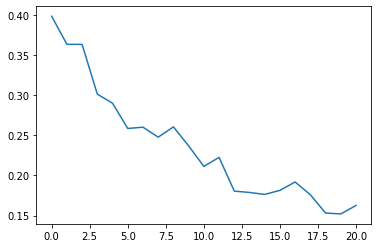

In [95]:
plt.plot(clf.history['loss'])

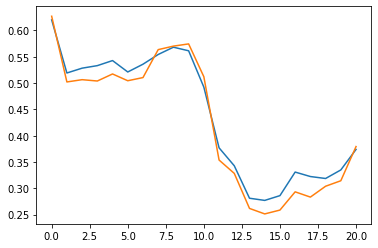

In [96]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

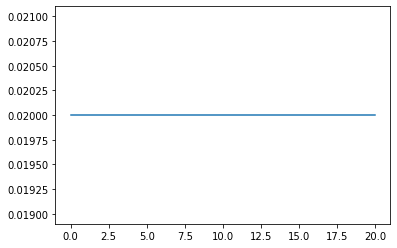

In [97]:
plt.plot(clf.history['lr'])

In [98]:
target = 'Class'

In [99]:
test_indices

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390],
           dtype='int64', length=2391)

In [100]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1430,1247.5,0.180888,0.970647,662,561,78.533838,classOne,0.088992,0.159958,...,0.773165,0.428583,1.196166,0.074062,0.078522,0.128689,0.069774,0.279889,0.044990,0
1,1431,9068.5,0.171969,0.972397,751,579,81.857239,classOne,0.126087,0.183584,...,0.589470,0.420638,1.365218,0.098366,0.093950,0.189146,0.091914,0.137530,0.048323,0
2,1432,2391.0,0.185029,0.969472,869,548,80.215418,classOne,0.100562,0.209148,...,0.581448,0.424211,1.336425,0.069207,0.206090,0.168276,0.133136,0.237812,0.049219,0
3,1433,2844.0,0.163861,0.975126,1252,619,26.679455,classOne,0.101059,0.309550,...,0.696221,0.425945,1.067160,0.080500,0.302677,0.165879,0.222617,0.340390,0.043068,0
4,1434,2188.5,0.176749,0.970335,842,510,78.065596,classOne,0.121961,0.209846,...,0.594424,0.461999,1.323560,0.085743,0.139873,0.207683,0.142900,0.387912,0.045935,0


Filename 2391
Class 2
Set 1


In [ ]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1430,1247.5,0.180888,0.970647,662,561,78.533838,1,0.088992,0.159958,...,0.773165,0.428583,1.196166,0.074062,0.078522,0.128689,0.069774,0.279889,0.044990,0
1,1431,9068.5,0.171969,0.972397,751,579,81.857239,1,0.126087,0.183584,...,0.589470,0.420638,1.365218,0.098366,0.093950,0.189146,0.091914,0.137530,0.048323,0
2,1432,2391.0,0.185029,0.969472,869,548,80.215418,1,0.100562,0.209148,...,0.581448,0.424211,1.336425,0.069207,0.206090,0.168276,0.133136,0.237812,0.049219,0
3,1433,2844.0,0.163861,0.975126,1252,619,26.679455,1,0.101059,0.309550,...,0.696221,0.425945,1.067160,0.080500,0.302677,0.165879,0.222617,0.340390,0.043068,0
4,1434,2188.5,0.176749,0.970335,842,510,78.065596,1,0.121961,0.209846,...,0.594424,0.461999,1.323560,0.085743,0.139873,0.207683,0.142900,0.387912,0.045935,0


In [ ]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD,LCS_STD,...,OFL,FDA,GABOR,OCL_STD2,LCS_STD2,OFL_STD2,FDA_STD2,RVU_STD2,GABOR_STD2,Set
0,1430,1247.5,0.180888,0.970647,662,561,78.533838,classOne,0.088992,0.159958,...,0.773165,0.428583,1.196166,0.074062,0.078522,0.128689,0.069774,0.279889,0.044990,0
1,1431,9068.5,0.171969,0.972397,751,579,81.857239,classOne,0.126087,0.183584,...,0.589470,0.420638,1.365218,0.098366,0.093950,0.189146,0.091914,0.137530,0.048323,0
2,1432,2391.0,0.185029,0.969472,869,548,80.215418,classOne,0.100562,0.209148,...,0.581448,0.424211,1.336425,0.069207,0.206090,0.168276,0.133136,0.237812,0.049219,0
3,1433,2844.0,0.163861,0.975126,1252,619,26.679455,classOne,0.101059,0.309550,...,0.696221,0.425945,1.067160,0.080500,0.302677,0.165879,0.222617,0.340390,0.043068,0
4,1434,2188.5,0.176749,0.970335,842,510,78.065596,classOne,0.121961,0.209846,...,0.594424,0.461999,1.323560,0.085743,0.139873,0.207683,0.142900,0.387912,0.045935,0


In [101]:
features

['Filename',
 'White Circle Patch',
 'Contrast',
 'Black Patch',
 'Biffercation',
 'Termination',
 'CID',
 'OCL_STD',
 'LCS_STD',
 'OFL_STD',
 'RPS',
 'FDA_STD',
 'RVU',
 'GABOR_STD',
 'GABORSHEN',
 'SIGMA',
 'MEAN',
 'OCL',
 'LCS',
 'OFL',
 'FDA',
 'GABOR',
 'OCL_STD2',
 'LCS_STD2',
 'OFL_STD2',
 'FDA_STD2',
 'RVU_STD2',
 'GABOR_STD2']

In [102]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_test)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.627009608066971
FINAL TEST SCORE : 0.6479381180733939


In [104]:
clf.predict(X_test)

array(['classZero', 'classZero', 'classZero', ..., 'classZero',
       'classZero', 'classZero'], dtype='<U9')

In [105]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [106]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [107]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.6479381180733939


In [108]:
assert(test_auc == loaded_test_auc)

In [109]:
loaded_clf.predict(X_test)

array(['classZero', 'classZero', 'classZero', ..., 'classZero',
       'classZero', 'classZero'], dtype='<U9')

In [110]:
clf.feature_importances_

array([1.85672570e-03, 1.07648690e-02, 6.44229466e-03, 5.19850037e-02,
       4.11248615e-01, 9.09133936e-02, 5.39533992e-02, 8.16566807e-02,
       3.71231953e-03, 6.21484898e-04, 1.80238641e-02, 5.26589892e-02,
       6.43428222e-02, 2.26895137e-03, 1.19089030e-02, 3.21436699e-02,
       5.98433564e-04, 3.88893114e-04, 2.00693188e-03, 5.03475671e-02,
       2.96041243e-05, 9.16338373e-04, 7.45427717e-03, 4.44154431e-03,
       7.71125552e-05, 6.31437657e-04, 8.69551078e-04, 3.77363228e-02])

In [111]:
explain_matrix, masks = clf.explain(X_test)

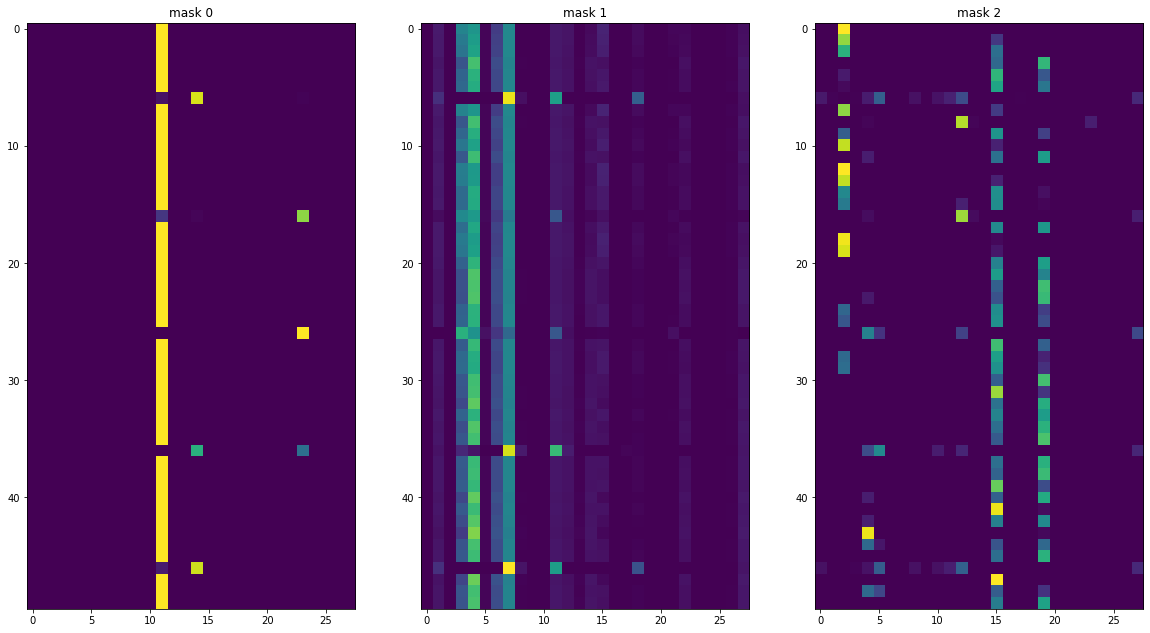

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")